In [36]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp


In [37]:
N = 8
M_sol = 2e30  #Solar mass
G = 6.6743e-11  #G in m^3 s^-2 kg^-1
au = 1.495978707e11 #Au in m
yr = 365.2422*24*3600 #Year in s
# G is now converted in AU^3 yr^-2 Msol^-1
G = G*au**-3*yr**2*M_sol
q = 1e-3  #softening factor
M = 1
t0, tf = 0, 2e4


The initial velocity for a circular motion with radius r has been calculated as $v = \sqrt{\frac{GM}{r}}$

In [38]:
#Velocity of a circular orbit give the radius
v_circ = lambda r, GM:  (GM/r)**0.5


For the integration has been used the reltive form of the equation of motion centered on the principal mass using the Encke-Bettin formulation to improve stability: $$ \ddot{\mathbf{r_i}} = -$$

In [39]:
def N_body(t,y,G,M,m):
  
  r_ = lambda y,i : y[[4*i, 4*i+1]]
  v_i = lambda y,i : y[[4*i+2, 4*i+3]]
  r_ij = lambda y,i,j,q: (np.linalg.norm(r_(y,i)-r_(y,j))**2+q**2)**0.5
  g = []
  
  for i in range(N):
    r_i = r_(y,i)
    g_i = -G*(M+m[i])*r_i/np.linalg.norm(r_i)**3
    for j in range(N):
      if i==j:
        continue
      else:
        #Perturbation part of the force
        #Encke-Bettin formulation 
        r_j = r_(y,j)
        q_ij = np.dot(r_i-2*r_j, r_i)/np.dot(r_j,r_j)
        f_ij = (3*q_ij + 3*q_ij**2 +q_ij**3)/(1+(1+q_ij)**1.5)
        
        p_ij = -G*m[j]*(r_i+f_ij*r_j)/r_ij(y,i,j,q)**3
        g_i = g_i + p_ij 
  
    g.append(g_i)

  dy = [[v_i(y,i), g[i]] for i in range(N)]
  return np.array(dy).flatten()


In [40]:

m = 1e-4*np.ones(shape=N)
y0 = [[r,0,0,v_circ(r, G*M)] for r in np.linspace(2, 16, N)]
y0= np.array(y0).flatten()

Y1 = solve_ivp(N_body, t_span=(t0,tf), y0=y0, args=(G,M,m), rtol=1e-10, dense_output=True)


In [56]:
T = np.linspace(t0,tf,int(1e4))
y = Y1.sol(T)
R = np.array([y[4*i : 4*i+2] for i in range(N)])
V = np.array([y[4*i+2 : 4*i+4] for i in range(N)])


r = np.array([np.linalg.norm(r_i, axis=0) for r_i in R])


K = 0.5*np.sum([m[i]*np.linalg.norm(V[i], axis=0)**2 for i in range(N)], axis=0)

#Potential energy between the masses
U_ij = np.sum([-G*m[i]*m[j]/np.linalg.norm(R[i]-R[j], axis=0) for i in range(N) for j in range(i)], axis=0)

#Potential energy between a mass and the central one
U_central = np.sum([-G*M*m[i]/r[i] for i in range(N)], axis=0)
E = K+U_central+U_ij

L = np.sum([m_i*np.cross(r_i, v_i, axis=0) for m_i, r_i, v_i in zip(m,R,V)], axis=0)




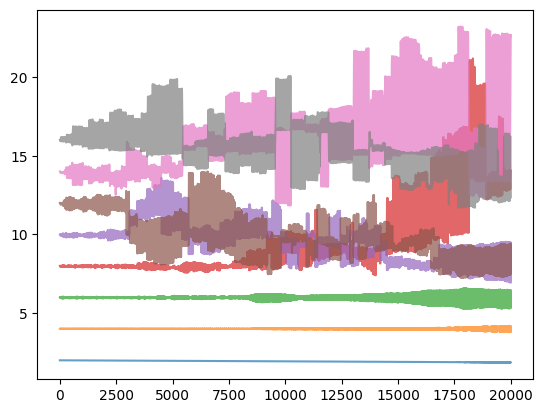

In [57]:
for r_i in r:
  plt.plot(T, r_i, alpha =0.7)
plt.show()


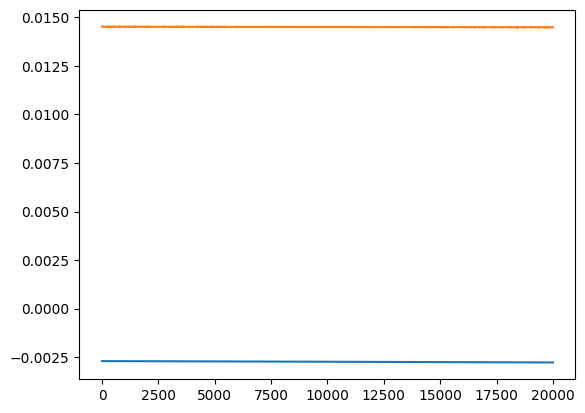

In [58]:
plt.plot(T, E)
plt.plot(T, L)
plt.show()
